# Importing necessary Libraries and Checking the Device specifications


In [5]:
# --- Core Libraries ---
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.cuda.amp import GradScaler, autocast

# --- Analytics & Visualization ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import random
import pickle
import warnings
warnings.filterwarnings('ignore')

# GPU Setup and Verification


In [6]:
# === GPU SETUP ===
def setup_gpu():
    if torch.cuda.is_available():
        device_count = torch.cuda.device_count()
        current_device = torch.cuda.current_device()
        device_name = torch.cuda.get_device_name(current_device)

        print("="*60)
        print("TRANSFER LEARNING - GPU CONFIGURATION")
        print("="*60)
        print(f"✅ CUDA Available: {torch.cuda.is_available()}")
        print(f"✅ PyTorch Version: {torch.__version__}")
        print(f"✅ GPU Count: {device_count}")
        print(f"✅ Current GPU: {current_device}")
        print(f"✅ GPU Name: {device_name}")

        gpu_memory = torch.cuda.get_device_properties(current_device).total_memory / 1e9
        print(f"✅ GPU Memory: {gpu_memory:.2f} GB")

        cudnn.benchmark = True
        cudnn.deterministic = True

        return f'cuda:{current_device}'
    else:
        print("❌ CUDA not available!")
        return 'cpu'

DEVICE = setup_gpu()
print("="*60)

TRANSFER LEARNING - GPU CONFIGURATION
✅ CUDA Available: True
✅ PyTorch Version: 2.6.0+cu124
✅ GPU Count: 2
✅ Current GPU: 0
✅ GPU Name: Tesla T4
✅ GPU Memory: 15.83 GB


# Importing the dataset

In [7]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

# --- Configuration ---
DATA_DIR_VARIETY = '/kaggle/input/fruitvision-a-benchmark-dataset-for-fresh/Fruits Original'

BATCH_SIZE = 32
IMG_SIZE = (224, 224)
LEARNING_RATE = 0.0001  # Lower LR for transfer learning
EPOCHS = 20
print(f"✅ Configuration: Batch={BATCH_SIZE}, Epochs={EPOCHS}, LR={LEARNING_RATE}")

# --- GPU Memory Management ---
def clear_gpu_memory():
    if DEVICE.startswith('cuda'):
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats(DEVICE)

def print_gpu_memory():
    if DEVICE.startswith('cuda'):
        allocated = torch.cuda.memory_allocated(DEVICE) / 1e9
        cached = torch.cuda.memory_reserved(DEVICE) / 1e9
        print(f"GPU Memory - Allocated: {allocated:.2f}GB, Cached: {cached:.2f}GB")

✅ Configuration: Batch=32, Epochs=20, LR=0.0001


# Data Transformers and DataLoaders

In [8]:
train_transforms = transforms.Compose([
    transforms.TrivialAugmentWide(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- GPU-Optimized DataLoader ---
def create_dataloaders(dataset_path, batch_size=32):
    full_dataset = datasets.ImageFolder(dataset_path)

    total_size = len(full_dataset)
    train_size = int(0.7 * total_size)
    val_size = int(0.15 * total_size)
    test_size = total_size - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

    train_dataset.dataset.transform = train_transforms
    val_dataset.dataset.transform = val_test_transforms
    test_dataset.dataset.transform = val_test_transforms

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                             num_workers=4, pin_memory=True, persistent_workers=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                           num_workers=4, pin_memory=True, persistent_workers=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                            num_workers=4, pin_memory=True, persistent_workers=True)

    return train_loader, val_loader, test_loader, train_size, val_size, test_size


# Transfer Learning Model Function

In [9]:
def create_transfer_model(model_name, num_classes, freeze_backbone=True):
    print(f"\n--- Creating {model_name} ---")

    if model_name == "efficientnet_b0":
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

        if freeze_backbone:
            for param in model.features.parameters():
                param.requires_grad = False
            print(f"✅ Backbone frozen for {model_name}")

        # Replace classifier
        model.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(model.classifier[1].in_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    elif model_name == "densenet121":
        model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)

        if freeze_backbone:
            for param in model.features.parameters():
                param.requires_grad = False
            print(f"✅ Backbone frozen for {model_name}")

        # Replace classifier
        model.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(model.classifier.in_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    else:
        raise ValueError(f"Model {model_name} not supported")

    # Count trainable parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"✅ Total params: {total_params:,}")
    print(f"✅ Trainable params: {trainable_params:,}")

    return model.to(DEVICE)

# Function Declaration

In [10]:
def train_transfer_model(model, model_name, train_loader, val_loader, epochs, lr, device, task_type):
    print(f"\n--- Training {model_name} for {task_type} ---")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                           lr=lr, weight_decay=1e-4)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, eta_min=1e-7)
    scaler = GradScaler()

    # Early stopping
    early_stopping_patience = 7
    min_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    clear_gpu_memory()

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            optimizer.zero_grad()

            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            if batch_idx % 100 == 0:
                torch.cuda.empty_cache()

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Calculate metrics
        avg_train_loss = train_loss / train_total
        avg_val_loss = val_loss / val_total
        avg_train_acc = train_correct / train_total
        avg_val_acc = val_correct / val_total

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(avg_train_acc)
        history['val_acc'].append(avg_val_acc)

        # Print progress
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {avg_train_acc:.4f} | Val Acc: {avg_val_acc:.4f} | "
              f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | LR: {current_lr:.6f}")

        scheduler.step()

        # Early stopping and model saving
        if avg_val_loss < min_val_loss:
            min_val_loss = avg_val_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict().copy()
            torch.save(model.state_dict(), f'{model_name}_{task_type.lower().replace(" ", "_")}_best.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        if epoch % 5 == 0:
            print_gpu_memory()

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    clear_gpu_memory()
    return history

# Model Evaluation and Metrics Defining Functions

In [11]:
# --- Evaluation Function ---
def evaluate_transfer_model(model, model_name, test_loader, class_names, device, task_type):
    print(f"\n--- Evaluating {model_name} for {task_type} ---")
    model.eval()
    y_pred, y_true = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device, non_blocking=True)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    # Calculate metrics
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0)
    accuracy = report['accuracy']
    f1_macro = report['macro avg']['f1-score']

    print(f"✅ Test Accuracy: {accuracy:.4f}")
    print(f"✅ F1-Macro Score: {f1_macro:.4f}")

    # Detailed report
    print("\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix: {model_name} ({task_type})', fontsize=14)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return {'accuracy': accuracy, 'f1_macro': f1_macro}

## EficientNet-80 Training

In [12]:
print("\n" + "="*60)
print("fruitvision-a-benchmark")
print("="*60)

# Load class information
class_names_variety = sorted(os.listdir(DATA_DIR_VARIETY))
NUM_CLASSES_VARIETY = len(class_names_variety)
print(f"Variety Classes ({NUM_CLASSES_VARIETY}): {class_names_variety}")

# Create data loaders
train_loader_v, val_loader_v, test_loader_v, train_size_v, val_size_v, test_size_v = create_dataloaders(
    DATA_DIR_VARIETY, BATCH_SIZE
)
print(f"Dataset sizes: Train={train_size_v}, Val={val_size_v}, Test={test_size_v}")

# === EFFICIENTNET-B0 FOR VARIETY CLASSIFICATION ===
print("\n" + "="*40)
print("EFFICIENTNET-B0 - VARIETY CLASSIFICATION")
print("="*40)

efficientnet_variety = create_transfer_model("efficientnet_b0", NUM_CLASSES_VARIETY, freeze_backbone=True)
history_eff_variety = train_transfer_model(efficientnet_variety, "EfficientNet-B0",
                                          train_loader_v, val_loader_v, EPOCHS,
                                          LEARNING_RATE, DEVICE, "Variety Classification")


fruitvision-a-benchmark
Variety Classes (6): ['Apple', 'Banana', 'Grape', 'Mango', 'Orange', 'desktop.ini']


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


Dataset sizes: Train=7107, Val=1523, Test=1524

EFFICIENTNET-B0 - VARIETY CLASSIFICATION

--- Creating efficientnet_b0 ---


100%|██████████| 20.5M/20.5M [00:00<00:00, 157MB/s]


✅ Backbone frozen for efficientnet_b0
✅ Total params: 4,796,290
✅ Trainable params: 788,742

--- Training EfficientNet-B0 for Variety Classification ---
Epoch 1/20 | Train Acc: 0.8969 | Val Acc: 0.9875 | Train Loss: 0.6190 | Val Loss: 0.0980 | LR: 0.000100
GPU Memory - Allocated: 0.06GB, Cached: 0.08GB
Epoch 2/20 | Train Acc: 0.9786 | Val Acc: 0.9934 | Train Loss: 0.0871 | Val Loss: 0.0372 | LR: 0.000090
Epoch 3/20 | Train Acc: 0.9841 | Val Acc: 0.9941 | Train Loss: 0.0579 | Val Loss: 0.0277 | LR: 0.000065
Epoch 4/20 | Train Acc: 0.9861 | Val Acc: 0.9934 | Train Loss: 0.0503 | Val Loss: 0.0235 | LR: 0.000035
Epoch 5/20 | Train Acc: 0.9856 | Val Acc: 0.9947 | Train Loss: 0.0455 | Val Loss: 0.0274 | LR: 0.000010
Epoch 6/20 | Train Acc: 0.9865 | Val Acc: 0.9947 | Train Loss: 0.0451 | Val Loss: 0.0188 | LR: 0.000100
GPU Memory - Allocated: 0.06GB, Cached: 0.32GB
Epoch 7/20 | Train Acc: 0.9865 | Val Acc: 0.9974 | Train Loss: 0.0400 | Val Loss: 0.0111 | LR: 0.000090
Epoch 8/20 | Train Acc: 0

## EficientNet-80 Evaluation

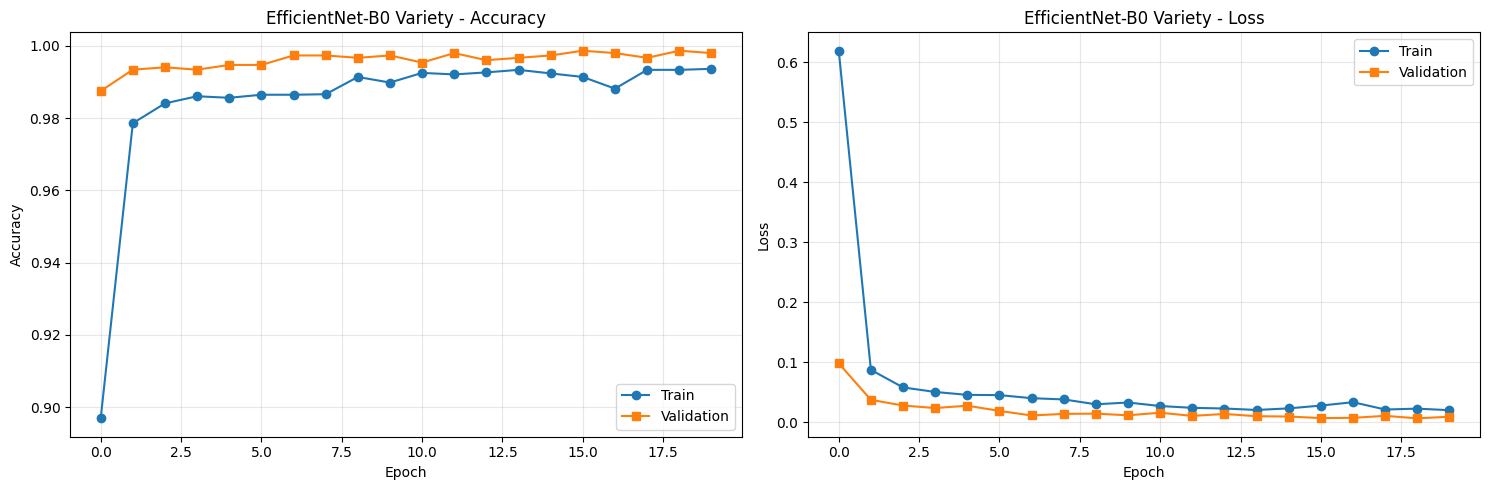


--- Evaluating EfficientNet-B0 for Variety Classification ---


ValueError: Number of classes, 5, does not match size of target_names, 6. Try specifying the labels parameter

In [13]:
# Plot training curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history_eff_variety['train_acc'], label='Train', marker='o')
plt.plot(history_eff_variety['val_acc'], label='Validation', marker='s')
plt.title('EfficientNet-B0 Variety - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_eff_variety['train_loss'], label='Train', marker='o')
plt.plot(history_eff_variety['val_loss'], label='Validation', marker='s')
plt.title('EfficientNet-B0 Variety - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Evaluate EfficientNet-B0
results_eff_variety = evaluate_transfer_model(efficientnet_variety, "EfficientNet-B0",
                                             test_loader_v, class_names_variety,
                                             DEVICE, "Variety Classification")

# Save model info
model_info_eff_variety = {
    'model_name': 'EfficientNet-B0_Variety',
    'architecture': 'EfficientNet-B0 (Transfer Learning)',
    'num_classes': NUM_CLASSES_VARIETY,
    'class_names': class_names_variety,
    'input_size': IMG_SIZE,
    'accuracy': results_eff_variety['accuracy'],
    'f1_macro': results_eff_variety['f1_macro'],
    'frozen_backbone': True,
    'epochs_trained': len(history_eff_variety['train_acc'])
}

with open('efficientnet_b0_variety_info.pkl', 'wb') as f:
    pickle.dump(model_info_eff_variety, f)

clear_gpu_memory()

## DenseNet-121 Training and evaluation


DENSENET121 - VARIETY CLASSIFICATION

--- Creating densenet121 ---


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 174MB/s]


✅ Backbone frozen for densenet121
✅ Total params: 7,611,526
✅ Trainable params: 657,670

--- Training DenseNet121 for Variety Classification ---
Epoch 1/20 | Train Acc: 0.8831 | Val Acc: 0.9875 | Train Loss: 0.5393 | Val Loss: 0.0595 | LR: 0.000100
GPU Memory - Allocated: 0.10GB, Cached: 0.13GB
Epoch 2/20 | Train Acc: 0.9741 | Val Acc: 0.9928 | Train Loss: 0.0898 | Val Loss: 0.0226 | LR: 0.000090
Epoch 3/20 | Train Acc: 0.9841 | Val Acc: 0.9947 | Train Loss: 0.0549 | Val Loss: 0.0173 | LR: 0.000065
Epoch 4/20 | Train Acc: 0.9882 | Val Acc: 0.9941 | Train Loss: 0.0439 | Val Loss: 0.0166 | LR: 0.000035
Epoch 5/20 | Train Acc: 0.9879 | Val Acc: 0.9915 | Train Loss: 0.0429 | Val Loss: 0.0181 | LR: 0.000010
Epoch 6/20 | Train Acc: 0.9878 | Val Acc: 0.9961 | Train Loss: 0.0410 | Val Loss: 0.0121 | LR: 0.000100
GPU Memory - Allocated: 0.10GB, Cached: 0.37GB
Epoch 7/20 | Train Acc: 0.9900 | Val Acc: 0.9915 | Train Loss: 0.0344 | Val Loss: 0.0195 | LR: 0.000090
Epoch 8/20 | Train Acc: 0.9899 | 

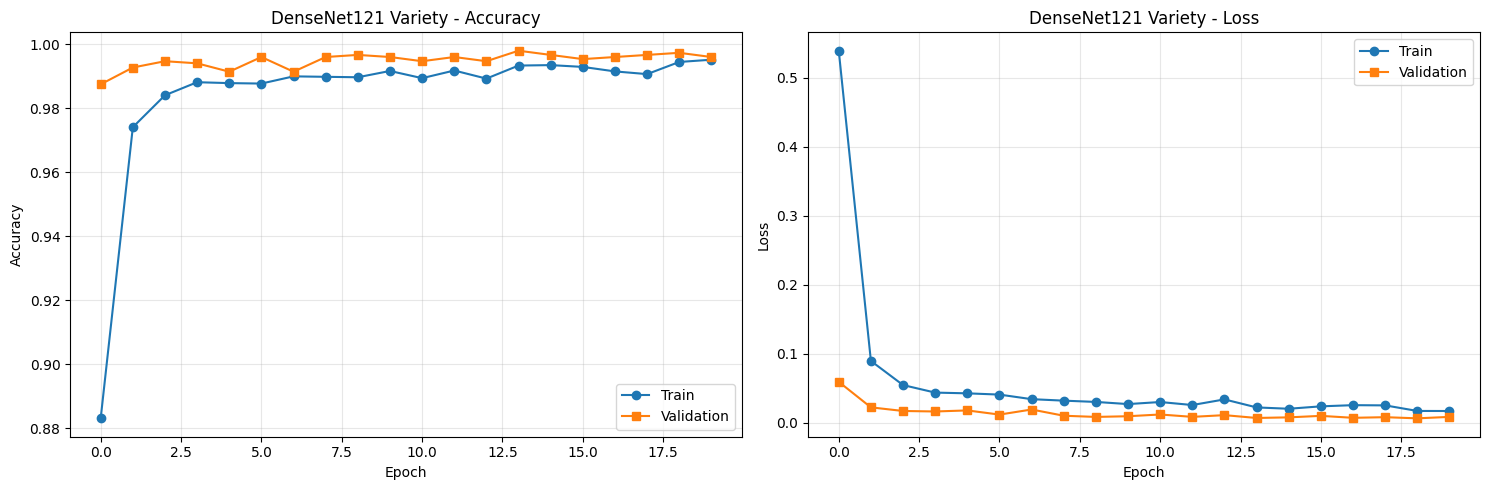


--- Evaluating DenseNet121 for Variety Classification ---


ValueError: Number of classes, 5, does not match size of target_names, 6. Try specifying the labels parameter

In [14]:
print("\n" + "="*40)
print("DENSENET121 - VARIETY CLASSIFICATION")
print("="*40)

densenet_variety = create_transfer_model("densenet121", NUM_CLASSES_VARIETY, freeze_backbone=True)
history_dense_variety = train_transfer_model(densenet_variety, "DenseNet121",
                                            train_loader_v, val_loader_v, EPOCHS,
                                            LEARNING_RATE, DEVICE, "Variety Classification")

# Plot training curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dense_variety['train_acc'], label='Train', marker='o')
plt.plot(history_dense_variety['val_acc'], label='Validation', marker='s')
plt.title('DenseNet121 Variety - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_dense_variety['train_loss'], label='Train', marker='o')
plt.plot(history_dense_variety['val_loss'], label='Validation', marker='s')
plt.title('DenseNet121 Variety - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Evaluate DenseNet121
results_dense_variety = evaluate_transfer_model(densenet_variety, "DenseNet121",
                                               test_loader_v, class_names_variety,
                                               DEVICE, "Variety Classification")

# Save model info
model_info_dense_variety = {
    'model_name': 'DenseNet121_Variety',
    'architecture': 'DenseNet121 (Transfer Learning)',
    'num_classes': NUM_CLASSES_VARIETY,
    'class_names': class_names_variety,
    'input_size': IMG_SIZE,
    'accuracy': results_dense_variety['accuracy'],
    'f1_macro': results_dense_variety['f1_macro'],
    'frozen_backbone': True,
    'epochs_trained': len(history_dense_variety['train_acc'])
}

with open('densenet121_variety_info.pkl', 'wb') as f:
    pickle.dump(model_info_dense_variety, f)

clear_gpu_memory()